In [198]:
from time import process_time
import matplotlib.pyplot as plt
import scipy
import psutil
import time

from qutip import *
from qutip.piqs import *

import scipy.integrate as integrate
from scipy.integrate import quad

import numpy as np
from numpy import linalg as LA
from IPython.display import display, clear_output

# Common parameters

In [199]:
def gauss(x, x_0, sigma):
    return 1*np.exp(-((x-x_0) / sigma) ** 2)

def ind_op(op1, op2, N_spin, index):
    # create a tensor product of op1 everywhere but at index, where it's op2
    # returns tensor_i!=index op1 tensor op2
    a = [op1] * N_spin
    a[index] = op2
    return tensor(a)

def sum_ops(op1, op2, N_spin, c):
    # sum of all permutations where all operators are op1 but one is op2
    return sum([c*ind_op(op1, op2, N_spin, i) for i in range(N_spin)])

In [200]:
# Model description
# Units in kHz
# /2pi

gk = 1.6 # kHz Coupling strength
kappa = 160. # kHz Cavity linewidth
gamma = 2000. #
Gamma = 0. # Dephasing

N_spin = 1e2 # Total number of emitters
N_cav = 30 # Fock states
k = 1 # Number of frequency classes
delta_c = 0. # wc-wp
sigma_c = 10.*kappa # Broadening STD

Delta_max = 5.*sigma_c
# delta_a = np.linspace(-Delta_max, Delta_max, k) # Spin inhomogenous broadening span
delta_a = 0.001*sigma_c
norm = np.sum(gauss(delta_a, 0, sigma_c))
ki = gauss(delta_a, delta_c, sigma_c)/norm*N_spin # Population distribution for each class 

# Square pulse
dt = 1/5*1/N_spin # Take into consideration of the fastest oscillation in the system
endtime = 4./gk
intervals = int(endtime/dt)
tlist = np.linspace(0, endtime, intervals)
tprep = 0.2 #us*endtime
F = 0. #kHz
Ft = F*np.append(np.ones(int(intervals*tprep)), np.zeros(int(intervals*(1-tprep))))
# Ft = np.zeros(intervals)

w_spin = delta_a - 1j*(gamma/2. + Gamma)
w_cav = delta_c - 1j*kappa/2.
print('Intervals = ', intervals)

Intervals =  1250


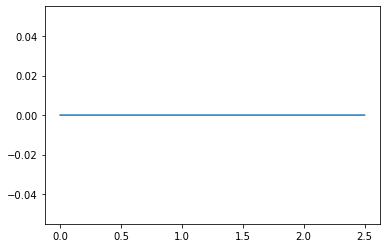

In [8]:
plt.plot(tlist, Ft)

# QuTiP

## Exact Solver

In [201]:
class exact_sys:
    
    def __init__(self, N_spin, N_cav, E_spin=True):
        # N_spin: number of spins
        # N_cav: the dimension of the Fock space, assume 0 excitation in the cavity
        # E_spin: bool, whether the spins are initially excited
        self.N_spin = N_spin
        self.N_cav = N_cav
        self.E_spin = E_spin
        self.ID_spin = tensor([qeye(2)]*N_spin)
        # Initial sate
        if E_spin:
            self.psi0 = tensor(basis(N_cav, 0), tensor([basis(2, 0)]*N_spin))
        else:
            self.psi0 =  psi0 = tensor(basis(N_cav, 0), tensor([basis(2, 1)]*N_spin))
        # Operators
        self.a = tensor(destroy(N_cav), self.ID_spin)
        self.ad = tensor(destroy(N_cav).dag(),self.ID_spin)
        self.sp = tensor(qeye(N_cav), sum_ops(qeye(2), sigmap(), N_spin, 1))
        self.sm = tensor(qeye(N_cav), sum_ops(qeye(2), sigmam(), N_spin, 1))
        self.sz = tensor(qeye(N_cav), sum_ops(qeye(2), sigmaz(), N_spin, 1))
        
        # Hamiltonian
        H0 = delta_c*self.ad*self.a + delta_a/2*self.sz + gk*(self.a*self.sp + self.ad*self.sm)
        self.H = [H0, [F*(self.ad+self.a), Ft]] 
    
    def __str__(self):
        return f'Exact solver for {self.N_spin} spins, Fock states = {self.N_cav}'
    
    def run_mesolve(self, tlist, c_ops, e_ops):
        start = time.time()
        out = mesolve(self.H, self.psi0, tlist, c_ops = c_ops, e_ops = e_ops)
        end = time.time()
        print(f'Run time: {end-start}s')
        return out

In [224]:
# Example use
exact = exact_sys(6, 20)
exact_out = exact.run_mesolve(tlist, [], [exact.sz])

Run time: 0.4726691246032715s


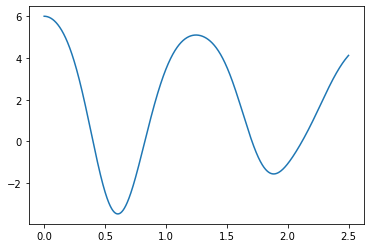

In [225]:
plt.plot(tlist, exact_out.expect[0])

## Permutational-invariant PIQS

In [208]:
class piqs_sys:
    def __init__(self, N_spin, N_cav, E_spin=True):
        self.N_spin = N_spin
        self.N_cav = N_cav
        self.E_spin = E_spin
        self.ID_spin = to_super(qeye(self.N_spin))
        self.ID_cav = to_super(qeye(self.N_cav))

        # Operators
        self.a = tensor(destroy(N_cav), self.ID_spin)
        self.ad = tensor(destroy(N_cav).dag(),self.ID_spin)
        self.sp = tensor(qeye(N_cav), sum_ops(qeye(2), sigmap(), N_spin, 1))
        self.sm = tensor(qeye(N_cav), sum_ops(qeye(2), sigmam(), N_spin, 1))
        self.sz = tensor(qeye(N_cav), sum_ops(qeye(2), sigmaz(), N_spin, 1))
        
        # Two-level operators
        nds = num_dicke_states(N_spin)
        [jx, jy, jz] = jspin(N_spin)
        jz = 2*jz
        jp, jm = jspin(N_spin, "+"), jspin(N_spin, "-")
        
        # Cavity operators
        a = destroy(N_cav)
        
        # System superoperators
        self.jz_tot = tensor(qeye(N_cav), jz)
        self.jm_tot = tensor(qeye(N_cav), jm)
        self.jpjm_tot = tensor(qeye(N_cav), jp*jm)
        self.a_tot = tensor(a, qeye(nds))
        self.ada_tot = tensor(a.dag()*a, qeye(nds))
        if self.E_spin:
            self.psi0 = tensor(fock_dm(N_cav,0), excited(N_spin, basis='dicke'))
        else:
            self.psi0 = tensor(fock_dm(N_cav,0), ground(N_spin, basis='dicke'))
        # Hamiltonian
        H_spin = delta_a/2 * self.jz_tot
        H_cav = delta_c * self.a_tot.dag() * self.a_tot
        H_int = gk * (self.a_tot.dag()*self.jm_tot + self.a_tot*self.jm_tot.dag())
        self.liouv = liouvillian(H_spin+H_cav+H_int)
        
        
    def __str__(self):
        if self.E_spin:
            return f'PIQS solver for {self.N_spin} excited spins, Fock states = {self.N_cav}'
        else:
            return f'PIQS solver for {self.N_spin} ground state spins, Fock states = {self.N_cav}'
    
    def run_mesolve(self, tlist, c_ops, e_ops):
        start = time.time()
        out = mesolve(self.liouv, self.psi0, tlist, c_ops = c_ops, e_ops = e_ops)
        end = time.time()
        print(f'Run time: {end-start}s')
        return out

Run time: 2.086487054824829s


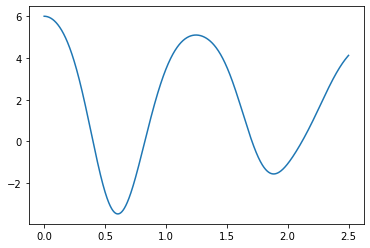

In [223]:
piq = piqs_sys(6,20)
piq_out = piq.run_mesolve(tlist, [], piq.jz_tot)
plt.plot(tlist, piq_out.expect[0])

## Plot comparison with the exact solver

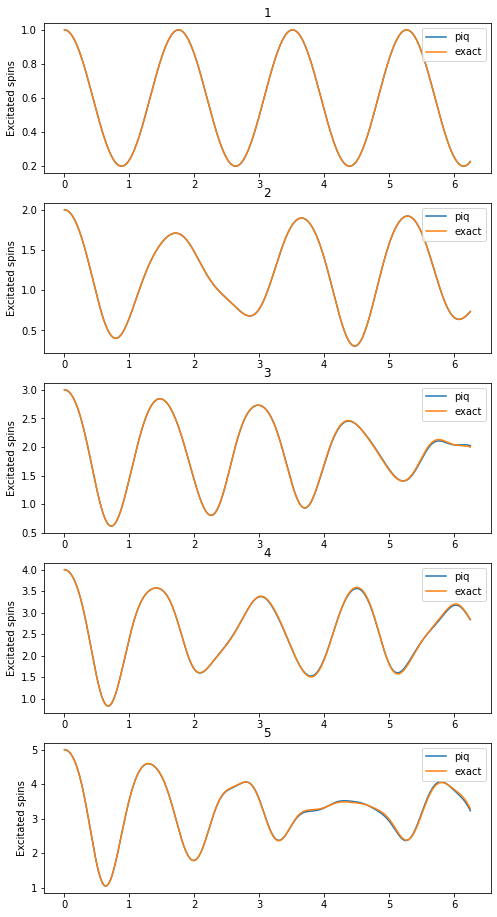

In [ ]:
fig, ax = plt.subplots(5,1, figsize=(8,16))
for i in range(Nmax):    
    ax[i].plot(tlist, n_ex_piq[i], label = 'piq')
    ax[i].plot(tlist, n_ex[i], label = 'exact')
    ax[i].legend()
    ax[i].set_ylabel('Excitated spins')
    ax[i].set_title(i+1)

In [ ]:
%%time
psi0_1 = tensor(basis(N_cav,0), basis(2,0))
a_1 = tensor(destroy(N_cav), qeye(2))
ad_1 = a_1.dag()
sp_1 = tensor(qeye(N_cav), sigmap())
sm_1 = sp_1.dag()
sz_1 = tensor(qeye(N_cav), sigmaz())
H0_1 = delta_c*ad_1*a_1 + delta_a/2.*sz_1 + gk*(a_1*sp_1 + ad_1*sm_1)
out1 = mesolve(H0_1, psi0_1, tlist, e_ops=[(sz+1)/2.])

CPU times: user 3.07 s, sys: 35.9 ms, total: 3.11 s
Wall time: 3.11 s


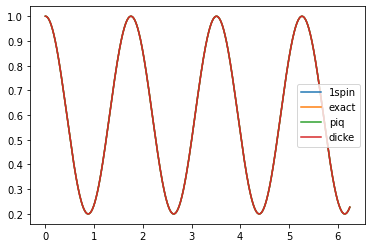

In [ ]:
plt.plot(tlist, out1.expect[0], label='1spin')
plt.plot(tlist, n_ex[0], label='exact')
plt.plot(tlist, n_ex_piq[0], label='piq')
plt.plot(tlist, out_p.expect[0], label='dicke')
plt.legend()

# Mean-field solver

## Test initialization

In [109]:
sys = tensor(basis(10,0), basis(2,1))
sigmap_1 = tensor(sigmap(), qeye(2))
sigmam_1 = tensor(sigmam(), qeye(2))
sigmaz_1 = tensor(sigmaz(), qeye(2))
sigmam_2 = tensor(qeye(2), sigmam())
sigmap_2 = tensor(qeye(2), sigmap())
sigmaz_2 = tensor(qeye(2), sigmaz())
a = tensor(destroy(10), qeye(2))
sm = tensor(qeye(10), sigmam())
expect(a*sz, sys)

0j

In [39]:
sys2 = tensor(basis(2,0),basis(2,0))
sz1 = tensor(sigmaz(), qeye(2))
sz2 = tensor(qeye(2), sigmaz())
sz = tensor(sigmaz(),sigmaz())
expect((sz1+sz2)**2, sys2)

4.0

## Mean-field equations (general)

In [218]:
class mean_field_sys:
    
    def __init__(self, k, w_spin, N_cav, w_cav, gk, gamma, kappa, F, end, dt, N_class=np.ones(k), E_spin=True, Int_2nd=False, sci=True):
        self.k = k
        self.N_class = N_class # Distirbution of spins in each class, k-D array
        self.N_cav = N_cav
        self.w_spin = w_spin
        self.w_cav = w_cav
        self.E_spin = E_spin
        if Int_2nd == True:
            self.Int_2nd = 1
        else:
            self.Int_2nd = 0
        self.sci = sci
        self.end = end
        self.dt = dt
        self.gk = gk
        self.gamma = gamma
        self.kappa = kappa
        self.intervals = int(self.end/self.dt)
        self.tlist = np.linspace(0, self.end, self.intervals)
        self.tprep = 0.2 #us*endtime
        self.F = F*np.append(np.ones(int(self.intervals*self.tprep)), np.zeros(int(self.intervals*(1-self.tprep)))) #kHz, strength* shape
        self.Ft = self.F[0]

        
        # Initialization
        self.a = 0+0j
        self.da = 0.
        self.ada = 0.
        self.dada = 0.
        self.a2 = 0.
        self.da2 = 0.
        self.sm = np.zeros(self.k, dtype=np.cfloat) 
        self.dsm = np.zeros(self.k, dtype=np.cfloat) 
        self.sp = np.zeros(self.k, dtype=np.cfloat)
        self.dsp = np.zeros(self.k, dtype=np.cfloat) 
        if E_spin:
            self.sz = np.ones(self.k, dtype=np.cfloat) # Added self.N_class*
        else:
            self.sz = -np.ones(self.k, dtype=np.cfloat)
        self.dsz = np.zeros(self.k, dtype=np.cfloat)

        self.a_sz = np.zeros(self.k, dtype=np.cfloat) # Product of expectation value of a and sz
        self.da_sz = np.zeros(self.k, dtype=np.cfloat) 
        self.a_sm = np.zeros(self.k, dtype=np.cfloat)
        self.da_sm = np.zeros(self.k, dtype=np.cfloat) 
        self.a_sp = np.zeros(self.k, dtype=np.cfloat)
        self.da_sp = np.zeros(self.k, dtype=np.cfloat) 
        
        # For different spins in then same class, each pair is equivalent
        self.sm_sz_s = np.zeros(self.k, dtype=np.cfloat)
        self.dsm_sz_s = np.zeros(self.k, dtype=np.cfloat) 
        self.sm_sp_s = np.zeros(self.k, dtype=np.cfloat)
        self.dsm_sp_s = np.zeros(self.k, dtype=np.cfloat) 
        self.sm_sm_s = np.zeros(self.k, dtype=np.cfloat)
        self.dsm_sm_s = np.zeros(self.k, dtype=np.cfloat) 
        self.sz_sz_s = np.ones(self.k, dtype=np.cfloat)
        self.dsz_sz_s = np.zeros(self.k, dtype=np.cfloat) 

        # Different class all set to 0, ignore if there is only one class
        self.sm_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self.dsm_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        if self.k>1:
            self.sz_sz_d = np.ones((self.k, self.k), dtype=np.cfloat)
        else:
            self.sz_sz_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self. dsz_sz_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        np.fill_diagonal(self.sz_sz_d, 0)
        self.sz_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self.dsz_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self.sp_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self.dsp_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        

    def __str__(self):
        if self.E_spin:
            return f'Mean-field solver for {self.N_spin} excited spins, Fock states = {self.N_cav}'
        else:
            return f'Mean-field solver for {self.N_spin} ground state spins, Fock states = {self.N_cav}'
        
    def cal_da(self):
        return (-1j * self.w_cav * self.a - 1j * self.gk * sum(self.N_class * self.sm) - 1j * self.Ft) 
    
    def cal_dda(self):
        return (-1j * self.w_cav * self.da - 1j * self.gk * sum(self.N_class * self.dsm))

    def cal_da2(self):
        return (-2j * self.w_cav * self.a2 - 2j * self.gk * np.sum(self.N_class * self.a_sm) - 2j * self.Ft * self.a) 
    
    def cal_dda2(self):
        return (-2j * self.w_cav * self.da2 - 2j * self.gk * np.sum(self.N_class * self.da_sm) - 2j * self.Ft * self.da)

    def cal_dada(self):
        return (-2 * self.gk * np.sum(self.N_class * np.imag(self.a_sp)) + 2 * self.Ft * np.imag(self.a) - self.kappa * self.ada)
    
    def cal_ddada(self):
        return (-2 * self.gk * np.sum(self.N_class * np.imag(self.da_sp)) + 2 * self.Ft * np.imag(self.da) - self.kappa * self.ada)

    def cal_dsm(self):
        return (-1j * self.w_spin * self.sm + 1j * self.a_sz * self.gk)

    def cal_ddsm(self):
        return (-1j * self.w_spin * self.dsm + 1j * self.da_sz * self.gk)

    def cal_dsz(self):
        return (4 * self.gk * np.imag(self.a_sp) - self.gamma * (1 + self.sz))
    
    def cal_ddsz(self):
        return (4 * self.gk * np.imag(self.da_sp) - self.gamma * self.dsz)

    def cal_da_sz(self):
        return (-1j * self.w_cav * self.a_sz - 1j * self.gk * (-self.sm + (self.N_class-1) * self.sm_sz_s) - \
                2j * self.gk * ((self.a2 * self.sp + 2 * self.a * self.a_sp - 2 * self.a**2 * self.sp) - (np.conjugate(self.a) * self.a_sm + self.a * np.conjugate(self.a_sp) +\
                 self.ada * self.sm - 2*np.abs(self.a)**2 * self.sm)) - self.gamma * (self.a + self.a_sz) - 1j * self.Ft * self.sz - \
                1j * self.gk * np.sum(self.sz_sm_d * self.N_class[..., None], axis=0)) # Assuming that N is a row vector of size k

    def cal_dda_sz(self):
        return (-1j * self.w_cav * self.da_sz - 1j * self.gk * (-self.dsm + (self.N_class-1) * self.dsm_sz_s) - \
                2j * self.gk * ((self.da2 * self.sp + self.da2 * self.dsp +  2 * (self.da * self.a_sp + self.a * self.da_sp) - 2 * (self.a**2 * self.dsp + 2*self.a*self.da*self.sp))\
                - (np.conjugate(self.da) * self.a_sm + np.conjugate(self.a) * self.da_sm + self.da * np.conjugate(self.a_sp) + self.a * np.conjugate(self.da_sp) +\
                 self.dada * self.sm + self.ada * self.dsm - 2*(np.abs(self.a)**2 * self.dsm + np.abs(self.a)*2 * self.da * self.sm)))\
                - self.gamma * (self.da + self.da_sz) - 1j * self.Ft * self.dsz - \
                1j * self.gk * np.sum(self.dsz_sm_d * self.N_class[..., None], axis=0))

    def cal_da_sm(self):
        return (-1j * (self.w_spin + self.w_cav) * self.a_sm - 1j * self.gk * ((self.N_class-1) * self.sm_sm_s - 2 * self.a_sz * self.a - self.a2 * self.sz\
                + 2 * self.a**2 * self.sz) - 1j * self.Ft * self.sm - 1j * self.gk * np.sum(self.sm_sm_d * self.N_class[..., None], axis=0))
    
    def cal_dda_sm(self):
        return (-1j * (self.w_spin + self.w_cav) * self.da_sm - 1j * self.gk * ((self.N_class-1) * self.dsm_sm_s - 2 * (self.da_sz * self.a + self.a_sz * self.da)\
                - (self.da2 * self.sz + self.a2 * self.dsz)+ 2 * (self.a**2 * self.dsz + self.a*2 * self.da * self.sz)) - 1j * self.Ft * self.dsm\
                - 1j * self.gk * np.sum(self.dsm_sm_d * self.N_class[..., None], axis=0))

    
    def cal_da_sp(self):
        return (1j * (np.conj(self.w_spin) - self.w_cav) * self.a_sp - .5j * self.gk * (1-self.sz) - 1j * self.gk * (self.N_class-1) * self.sm_sp_s\
                -1j * self.gk * np.sum(self.sp_sm_d * self.N_class[..., None], axis=0) - 1j * self.gk * ((1+self.ada) * self.sz + 2 * np.real(self.a * np.conjugate(self.a_sz)) - 2 * np.abs(self.a)**2 * self.sz)\
                -1j * self.Ft * self.sp)
    
    def cal_dda_sp(self):
        return (1j * (np.conj(self.w_spin) - self.w_cav) * self.da_sp + .5j * self.gk * self.dsz - 1j * self.gk * (self.N_class-1) * self.dsm_sp_s\
                -1j * self.gk * np.sum(self.dsp_sm_d * self.N_class[..., None], axis=0) - 1j * self.gk * ((1+self.ada) * self.dsz + self.sz * self.dada \
                + 2 * np.real(self.da * np.conjugate(self.a_sz) + self.a * np.conjugate(self.da_sz)) - 2 * (np.abs(self.a)**2 * self.dsz + np.abs(self.a)*2 * self.da * self.sz))\
                -1j * self.Ft * self.dsp)

    def cal_dsm_sz_s(self):
        ad = np.conjugate(self.a)
        return (-1j * self.w_spin * self.sm_sz_s + 1j * self.gk * (self.a * self.sz_sz_s + 2 * self.sz * self.a_sz - 2 * self.a * self.sz**2)- 2j * self.gk\
            *(self.a_sm * self.sp + self.a_sp * self.sm + self.a * self.sm_sp_s - 2 * self.a * self.sm * self.sp - (ad * self.sm_sm_s + 2*np.conjugate(self.a_sp) * self.sm\
            - 2 * ad * self.sm**2)) - self.gamma*(self.sm + self.sm_sz_s))
    
    def cal_ddsm_sz_s(self):
        return (-1j * self.w_spin * self.dsm_sz_s + 1j * self.gk * (self.da * self.sz_sz_s + self.a * self.dsz_sz_s + 2 * self.dsz * self.a_sz + 2 * self.sz * self.da_sz\
                - 2 * self.da * self.sz**2 - 2 * self.a * self.sz*2 * self.dsz)- 2j * self.gk *(self.da_sm * self.sp + self.a_sm * self.dsp + \
                self.da_sp * self.sm + self.a_sp * self.dsm + self.da * self.sm_sp_s + self.a * self.dsm_sp_s - 2 * (self.da * self.sm * self.sp + self.a * self.dsm * self.sp + self.a * self.sm * self.dsp)\
                - (np.conjugate(self.da) * self.sm_sm_s + np.conjugate(self.a) * self.dsm_sm_s + 2*np.conjugate(self.da_sp) * self.sm + 2*np.conjugate(self.a_sp) * self.dsm\
                - 2 * (np.conjugate(self.da) * self.sm**2 + np.conjugate(self.a) * self.sm*2 * self.dsm))) - self.gamma*(self.dsm + self.dsm_sz_s))

    def cal_dsm_sp_s(self):
        return (2 * np.imag(self.w_spin) * self.sm_sp_s + \
                2* self.gk * np.imag(self.sz * np.conjugate(self.a_sp) + \
                np.conjugate(self.a) * self.sm_sz_s + self.sm * np.conjugate(self.a_sz)-\
                2 * np.conjugate(self.a)* self.sm * self.sz))
    
    def cal_ddsm_sp_s(self):
        return (2 * np.imag(self.w_spin) * self.dsm_sp_s + \
                2* self.gk * np.imag(self.dsz * np.conjugate(self.a_sp) + self.sz * np.conjugate(self.da_sp) +\
                np.conjugate(self.da) * self.sm_sz_s + np.conjugate(self.a) * self.dsm_sz_s + self.dsm * np.conjugate(self.a_sz) + self.sm * np.conjugate(self.da_sz)-\
                2 * (np.conjugate(self.da)* self.sm * self.sz + np.conjugate(self.a)* self.dsm * self.sz + np.conjugate(self.a)* self.sm * self.dsz)))

    def cal_dsm_sm_s(self):
        return (-2j * self.w_spin * self.sm_sm_s + 2j * self.gk * (self.a * self.sm_sz_s + self.a_sm * self.sz + self.a_sz * self.sm-\
                    2 * self.a * self.sm * self.sz))
    
    def cal_ddsm_sm_s(self):
        return (-2j * self.w_spin * self.dsm_sm_s + 2j * self.gk * (self.da * self.sm_sz_s + self.a * self.dsm_sz_s + self.da_sm * self.sz + self.a_sm * self.dsz \
                + self.da_sz * self.sm + self.a_sz * self.dsm - 2 * (self.da * self.sm * self.sz + self.a * self.dsm * self.sz + self.a * self.sm * self.dsz )))

    def cal_dsz_sz_s(self):
        return (8 * self.gk * np.imag(self.a * np.conjugate(self.sm_sz_s) + self.a_sp * self.sz + self.a_sz * self.sp - 2 * self.a * self.sp * self.sz) - \
                   2 *self.gamma * (self.sz + self.sz_sz_s))
    
    def cal_ddsz_sz_s(self):
        return (8 * self.gk * np.imag(self.da * np.conjugate(self.sm_sz_s) + self.a * np.conjugate(self.dsm_sz_s) + self.da_sp * self.sz + self.a_sp * self.dsz + \
                self.da_sz * self.sp + self.a_sz * self.dsp - 2 * (self.da * self.sp * self.sz + self.a * self.dsp * self.sz + self.a * self.sp * self.dsz)) - \
                   2 *self.gamma * (self.dsz + self.dsz_sz_s))

    def cal_dsm_sm_d(self):
        N = np.size(self.w_spin)
        w_spin_r = np.tile(self.w_spin, N).reshape(N, N)
        w_spin_c = w_spin_r.T
        a_sz_c = np.vstack(self.a_sz)
        sm_c = np.vstack(self.sm)
        a_sm_c = np.vstack(self.a_sm)
        sz_c = np.vstack(self.sz)

        d = (-1j * (w_spin_r + w_spin_c) * self.sm_sm_d + \
                   1j * self.gk * (self.a * self.sz_sm_d + sm_c * self.a_sz + self.sz * a_sm_c - 2 * self.a * self.sz * sm_c)\
                   + 1j * self.gk * (self.a * self.sz_sm_d.T + self.sm * a_sz_c + sz_c * self.a_sm - 2 * self.sm * sz_c))
        np.fill_diagonal(d, 0)
        return d

    def cal_dsz_sz_d(self):
        N = np.size(self.sz)
        a_sz_c = np.vstack(self.a_sz)
        a_sp_c = np.vstack(self.a_sp)
        sp_c = np.vstack(self.sp)
        sz_c = np.vstack(self.sz)
        sz_mat_c = np.tile(sz_c, N)
        sz_mat_r = np.tile(self.sz, N).reshape(N, N)

        d = (4 * self.gk * np.imag(self.a * np.conjugate(self.sz_sm_d).T + \
                    self.sp * a_sz_c + self.a_sp * sz_c - 2 * self.a * self.sp * sz_c) + \
                   4 * self.gk * np.imag(self.a * np.conjugate(self.sz_sm_d) + \
                    self.a_sz * sp_c + self.sz * a_sp_c - 2 * self.a * self.sz * sp_c) -
                   self.gamma*(sz_mat_c + sz_mat_r + 2 * self.sz_sz_d))
        np.fill_diagonal(d, 0)
        return d

    def cal_dsz_sm_d(self):
        ad = np.conjugate(self.a)
        N = np.size(self.sm)
        w_spin_c = np.vstack(self.w_spin)
        sz_c = np.vstack(self.sz)
        sm_c = np.vstack(self.sm)
        a_sm_c = np.vstack(self.a_sm)
        a_sz_c = np.vstack(self.a_sz)
        ad_sm = np.conjugate(self.a_sp)
        ad_sm_c = np.vstack(self.ad_sm)
        sm_mat_c = np.tile(self.sm_c, N)

        d = (-1j * w_spin_c * self.sz_sm_d\
                    + 1j * self.gk * (self.a * self.sz_sz_d + self.a_sz * sz_c + a_sz_c * self.sz\
                   - 2 * self.a * self.sz * sz_c) - 2j * self.gk * ((self.a * self.sp_sm_d + self.a_sp * sm_c + a_sm_c * self.sp - 2 * self.a * self.sp * sm_c)\
                   -(ad * self.sm_sm_d + self.ad_sm * sm_c + ad_sm_c * self.sm - 2 * self.ad * self.sm *sm_c))\
                   -self.gamma * (sm_mat_c + self.sz_sm_d))
        np.fill_diagonal(d, 0)
        return d

    def cal_dsp_sm_d(self):
        ad = np.conjugate(self.a)
        w_spin_c = np.vstack(self.w_spin)
        sp_sz_d = np.conjugate(self.sz_sm_d).T
        ad_sz = np.conjugate(self.a_sz)
        ad_sm_c = np.conjugate(self.a_sp).T
        sz_c = np.vstack(self.sz)
        sm_c = np.vstack(self.sm)
        a_sz_c = np.vstack(self.a_sz)
        d = (-1j * (w_spin_c - np.conjugate(self.w_spin) * self.sp_sm_d + 1j * self.gk*\
                    (self.a * self.sp_sz_d) + self.a_sp * sz_c + a_sz_c * self.sz - 2 * self.a * self.sp * sz_c)-1j * self.gk *\
                    (ad * self.sz_sm_d + ad_sz * sm_c + ad_sm_c * self.sz - 2 * self.ad * self.sz * sm_c))
        np.fill_diagonal(d,0)
        return d
    
    def bound(self, ub, val, val_pre):
        
        # val: the newly evaluated expectation of increments
        # val_pre: the expectation of increment from last iteration
        
        val_abs = np.abs(val)
        if val_abs > abs(ub):
            return val_pre
        else:
            return val
    
    def update(self):
        n_sz = np.zeros(self.intervals, dtype=np.cfloat)
        n_ada = np.zeros(self.intervals, dtype=np.cfloat)
        start = time.time()
        t = 0 # not used, positional variable
        for i in range(self.intervals):
            n_sz[i] = self.sz
            n_ada[i] = self.ada
            self.da = self.cal_da() * self.dt
            self.dada = self.cal_dada() * self.dt
            self.da2 = self.cal_da2() * self.dt
            self.dsm = self.cal_dsm() * self.dt
            self.dsz = self.cal_dsz() * self.dt
            self.da_sz = self.cal_da_sz() * self.dt
            self.da_sm = self.cal_da_sm() * self.dt
            self.da_sp = self.cal_da_sp() * self.dt
            self.dsm_sz_s = self.cal_dsm_sz_s() * self.dt
            self.dsm_sp_s = self.cal_dsm_sp_s() * self.dt
            self.dsm_sm_s = self.cal_dsm_sm_s() * self.dt
            self.dsz_sz_s = self.cal_dsz_sz_s() * self.dt
            if self.k > 1:
                self.dsm_sm_d = self.cal_dsm_sm_d() * self.dt
                self.dsz_sz_d = self.cal_dsz_sz_d() * self.dt
                self.dsz_sm_d = self.cal_dsz_sm_d() * self.dt
                self.dsp_sm_d = self.cal_dsp_sm_d() * self.dt
                
            self.a = self.bound(self.N_class, self.a + self.da + .5* self.cal_dda() * self.Int_2nd * self.dt**2, self.a)
            self.ada = self.bound(self.N_class, self.ada + self.dada + .5*self.cal_ddada() * self.Int_2nd  * self.dt**2, self.ada)
            self.a2 = self.bound(self.a**2, self.a2 + self.da2 + .5*self.cal_dda2() * self.Int_2nd  * self.dt**2, self.a2)
            self.sm = self.bound(1, self.sm + self.dsm + .5*self.cal_ddsm() * self.Int_2nd  * self.dt**2, self.sm)
            self.sz = self.bound(1, self.sz + self.dsz + .5*self.cal_ddsz() * self.Int_2nd  * self.dt**2, self.sz)
            self.a_sz += self.da_sz + .5*self.cal_dda_sz() * self.Int_2nd  * self.dt**2
            self.a_sm += self.da_sm + .5*self.cal_dda_sm() * self.Int_2nd  * self.dt**2
            self.a_sp += self.da_sp + .5*self.cal_dda_sp() * self.Int_2nd  * self.dt**2
            # self.sm_sz_s = self.bound(1, self.dsm_sz_s + .5*self.cal_ddsm_sz_s() * self.Int_2nd  * self.dt**2, self.sm_sz_s)
            # self.sm_sp_s = self.bound(1, self.dsm_sp_s + .5*self.cal_ddsm_sp_s() * self.Int_2nd  * self.dt**2, self.sm_sp_s)
            # self.sm_sm_s = self.bound(1, self.dsm_sm_s + .5*self.cal_ddsm_sm_s() * self.Int_2nd  * self.dt**2, self.sm_sm_s)
            self.sm_sz_s += self.dsm_sz_s + .5*self.cal_ddsm_sz_s() * self.Int_2nd  * self.dt**2
            self.sm_sp_s += self.dsm_sp_s + .5*self.cal_ddsm_sp_s() * self.Int_2nd  * self.dt**2
            self.sm_sm_s += self.dsm_sm_s + .5*self.cal_ddsm_sm_s() * self.Int_2nd  * self.dt**2
            self.sz_sz_s = self.bound(1, self.dsz_sz_s + .5*self.cal_ddsz_sz_s() * self.Int_2nd  * self.dt**2, self.sz_sz_s)
            
        end = time.time()
        print(f'Run time: {end-start}s')
        return [n_sz, n_ada]

In [233]:
mean3 = mean_field_sys(1, delta_a, N_cav, delta_c, gk, 0, 0, 0, 5./gk, dt/5, N_class = np.asarray([6]))
[n_sz, n_ada] = mean3.update()

Run time: 3.8116490840911865s


/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(1.9999955865562185+0j)

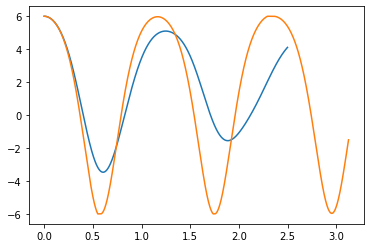

In [234]:
end = -1
plt.plot(tlist[:end], exact_out.expect[0][:end])
plt.plot(mean3.tlist[:end], n_sz[:end]*6)
max(n_sz)-min(n_sz)

In [129]:
class trial_mean:
    def __init__(self, a, b, dt, direct=True):
        self.a = a
        self.b = b
        self.dt = dt
        self.direct = direct
        self.endtime = 10
        self.steps = int(self.endtime/self.dt)
        self.tlist = np.linspace(0,self.endtime, self.steps)
    
    def da(self):
        return (3*self.a+self.b)/2
    def db(self):
        return (self.a-7*self.b)/2
    
    def update_direct(self):
        print(f'{self.steps} Steps')
        start = time.time()
        na = np.zeros(self.steps)
        nb = np.zeros(self.steps)
        if self.direct:
            for i in range(self.steps):
                na[i] = self.a
                nb[i] = self.b
                self.a = self.a + self.da(0)*self.dt
                self.b = self.b + self.db(0)*self.dt
        else:
            for i in range(self.steps):
                na[i] = self.a
                nb[i] = self.b
                da = quad(lambda t: self.da(t), 0, self.dt)[0]
                db = quad(lambda t: self.db(t), 0, self.dt)[0]
                self.a += da
                self.b += db
                
        end = time.time()
        print(f'Run time: {end-start}s')
        return [na, nb]     

In [134]:
direct_conv = trial_mean(5,10, 0.01)
results_conv = direct_conv.update_direct()
direct_1 = trial_mean(5,10, 0.1)
results_1 = direct_1.update_direct()

1000 Steps
Run time: 0.0012316703796386719s
100 Steps
Run time: 8.58306884765625e-05s


In [135]:
direct_2 = trial_mean(5,10, 0.1, False)
results_2 = direct_2.update_direct()
plt.plot(direct_2.tlist, results_2[0], label = 'quad')
plt.plot(direct_conv.tlist, results_conv[0], label = 'direct_conv')
plt.plot(direct_1.tlist, results_1[0], label = 'direct')
plt.legend()

100 Steps


TypeError: da() takes 1 positional argument but 2 were given

## Initialization 1 class

In [10]:
k = 1
kappa = 0. # cavity decay/linewidth
gamma = 0.
Gamma = 0.
w_spin = delta_a - 1j*(gamma/2. + Gamma)
w_cav = delta_c - 1j*kappa/2.
a_0 = 0. # Cavity initialized in vacuum
a2_0 = 0.
ada_0 = 0.

sm_0 = np.zeros(k, dtype=np.cfloat) # Spins originally excited
sp_0 = np.zeros(k, dtype=np.cfloat)
sz_0 = np.ones(k, dtype=np.cfloat) 

a_sz_0 = np.zeros(k, dtype=np.cfloat) # Product of expectation value of a and sz
a_sm_0 = np.zeros(k, dtype=np.cfloat)
a_sp_0 = np.zeros(k, dtype=np.cfloat)

sm_sz_s_0 = np.zeros(k, dtype=np.cfloat)
sm_sp_s_0 = np.zeros(k, dtype=np.cfloat)
sm_sm_s_0 = np.zeros(k, dtype=np.cfloat)
sz_sz_s_0 = np.ones(k, dtype=np.cfloat)

# Different class all set to 0
sm_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)
sz_sz_d_0 = np.zeros((k, k), dtype=np.cfloat)
#np.fill_diagonal(sz_sz_d_0, 0)
sz_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)
sp_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)

Ft = F*Ft

## Main function

In [13]:
def da(a, dt, sm, Ft, N):
    a += (-1j*w_cav*a - gk*1j*np.sum(N*sm) - 1j*Ft)*dt
    return a
    
def da2(a2, dt, N, a_sm, a_sp, a, Ft):
    a2 += (-2j*w_cav*a2-2j*gk*np.sum(N*(a_sm + a_sp)) - 2j*Ft*a)*dt
    return a2

def dada(ada, dt, a_sp, Ft, a, N):
    ada += (-2*gk*np.sum(N*a_sp)-2j*Ft*np.imag(a)-kappa*ada)*dt
    return ada

def dsm(sm, dt, w_spin, a_sz):
    sm += (-1j*w_spin + 1j*a_sz*gk)*dt
    return sm

def dsz(sz, dt, a_sp):
    sz += (4*gk*np.imag(a_sp) - gamma*(1+sz))*dt
    return sz

def da_sz(a_sz, dt, sz, N, sm_sz_s, sz_sm_d, a2, a_sp, a, sp, ada, a_sm, sm, Ft):
    a_sz += (-1j*w_spin*a_sz - 1j*gk*(sz + (N-1)*sm_sz_s) - \
            2j*gk*((a2*sp + 2*a*a_sp - 2*a**2*sp) - (a*np.conj(a_sp) + np.conj(a)*a_sm + (1+ada)*sm-2*np.abs(a)**2*sm))\
            - gamma*(a + a_sz) - 1j*Ft*sz - \
            1j*gk*np.sum(sz_sm_d*N[..., None], axis=0))*dt # Assuming that N is a row vector of size k
    return a_sz

def da_sm(a_sm, dt, sm_sm_d, N, sm_sm_s, a2, a, sz, a_sz, sm, Ft):
    a_sm += (-1j*(w_spin+w_cav)*a_sm - 1j*gk*((N-1)*sm_sm_s - 2*a_sz*a - a2*sz\
            + 2*a**2*sz)-1j*Ft*sm -1j*gk*np.sum(sm_sm_d*N[..., None], axis=0))*dt
    return a_sm

def da_sp(a_sp, dt, sz, N, sm_sp_s, sp_sm_d, a, a_sz, ada, Ft, sp):
    ad = np.conjugate(a)
    a_sp += (1j*(np.conjugate(w_spin)-w_cav)*a_sp-.5j*gk*(1-sz)-1j*gk*(N-1)*sm_sp_s\
            -1j*np.sum(sp_sm_d*N[..., None], axis=0)-1j*gk*((1+ada)*sz + 2* np.real(a_sz*ad) -2*np.abs(a)**2*sz)\
            -1j*Ft*sp)*dt
    return a_sp

def dsm_sz_s(sm_sz_s, dt, a, sz, a_sz, sz_sz_s, a_sm, a_sp, sm_sp_s, sp, sm, sm_sm_s):
    ad = np.conjugate(a)
    sm_sz_s += (-1j*w_spin*sm_sz_s+1j*gk*(a*sz_sz_s+2*sz*a_sz-2*a*sz**2)-2j*gk\
    *(a_sm*sp+a_sp*sm+a*sm_sp_s-2*a*sm*sp-(ad*sm_sm_s+2*np.conjugate(a_sp)*sm\
    -2*ad*sm**2))-gamma*(sm+sz_sz_s))*dt
    return sm_sz_s

def dsm_sp_s(sm_sp_s, dt, a, sm_sz_s, a_sp, a_sz, sz, sm):
    sm_sp_s += (2*np.imag(w_spin)*sm_sp_s + \
               2*gk*np.imag(sz*np.conjugate(a_sp)+\
                           np.conjugate(a)*sm_sz_s+sm*np.conjugate(a_sz)-\
                          2*np.conjugate(a)*sm*sz))*dt
    return sm_sp_s

def dsm_sm_s(sm_sm_s, dt, a_sm, a_sz, sm_sz_s, sm, sz, a):
    sm_sm_s += (-2j*w_spin*sm_sm_s+2j*gk*(a*sm_sz_s+a_sm*sz+a_sz*sm-\
                2*a*sm*sz))*dt
    return sm_sm_s

def dsz_sz_s(sz_sz_s, dt, sm_sz_s, sz):
    sz_sz_s += (8*gk*np.imag(np.conjugate(sm_sz_s)) - \
               2*gamma*(sz + sz_sz_s))*dt
    return sz_sz_s

def dsm_sm_d(sm_sm_d, dt, a, sz, sm, a_sz, a_sm, sz_sm_d):
    N = np.size(w_spin)
    w_spin_r = np.tile(w_spin, N).reshape(N, N)
    w_spin_c = w_spin_r.T
    a_sz_c = np.vstack(a_sz)
    sm_c = np.vstack(sm)
    a_sm_c = np.vstack(a_sm)
    sz_c = np.vstack(sz)
    
    sm_sm_d += (-1j*(w_spin_r + w_spin_c)*sm_sm_d + \
               1j*gk*(a*sz_sm_d + sm_c*a_sz + sz*a_sm_c - 2*a*sz*sm_c)\
               +1j*gk*(a*sz_sm_d.T + sm*a_sz_c+sz_c*a_sm - 2*sm*sz_c))*dt
    
    np.fill_diagonal(sm_sm_d, 0)
    
    return sm_sm_d

def dsz_sz_d(sz_sz_d, dt, a_sp, a_sz, sz_sm_d, a, sp, sz):
    N = np.size(sz)
    a_sz_c = np.vstack(a_sz)
    a_sp_c = np.vstack(a_sp)
    sp_c = np.vstack(sp)
    sz_c = np.vstack(sz)
    sz_mat_c = np.tile(sz_c, N)
    sz_mat_r = np.tile(sz, N).reshape(N, N)
    
    sz_sz_d += (4*gk*np.imag(a*np.conjugate(sz_sm_d).T + \
                sp*a_sz_c + a_sp*sz_c - 2*a*sp*sz_c) + \
               4*gk*np.imag(a*np.conjugate(sz_sm_d) + \
                a_sz*sp_c + sz*a_sp_c - 2*a*sz*sp_c) -
               gamma*(sz_mat_c + sz_mat_r + 2*sz_sz_d))*dt
    np.fill_diagonal(sz_sz_d, 0)
    return sz_sz_d

def dsz_sm_d(sz_sm_d, dt, a_sz, sz_sz_d, sz, a, sp_sm_d, sp, sm, a_sp, a_sm, sm_sm_d):
    ad = np.conjugate(a)
    N = np.size(sm)
    w_spin_c = np.vstack(w_spin)
    sz_c = np.vstack(sz)
    sm_c = np.vstack(sm)
    a_sm_c = np.vstack(a_sm)
    a_sz_c = np.vstack(a_sz)
    ad_sm = np.conjugate(a_sp)
    ad_sm_c = np.vstack(ad_sm)
    sm_mat_c = np.tile(sm_c, N)
    
    sz_sm_d += (-1j*w_spin_c*sz_sm_d\
                + 1j*gk*(a*sz_sz_d + a_sz*sz_c + a_sz_c*sz\
               -2*a*sz*sz_c) - 2j*gk*((a*sp_sm_d + a_sp*sm_c + a_sm_c*sp - 2*a*sp*sm_c)\
               -(ad*sm_sm_d + ad_sm*sm_c + ad_sm_c*sm - 2*ad*sm*sm_c))\
               -gamma*(sm_mat_c + sz_sm_d))*dt
    np.fill_diagonal(sz_sm_d, 0)
    return sz_sm_d

def dsp_sm_d(sp_sm_d, dt, sz_sm_d, a_sp, a_sz, sp, sz, sm, a):
    ad = np.conjugate(a)
    w_spin_c = np.vstack(w_spin)
    sp_sz_d = np.conjugate(sz_sm_d).T
    ad_sz = np.conjugate(a_sz)
    ad_sm_c = np.conjugate(a_sp).T
    sz_c = np.vstack(sz)
    sm_c = np.vstack(sm)
    a_sz_c = np.vstack(a_sz)
    sp_sm_d += (-1j*(w_spin_c-np.conjugate(w_spin)*sp_sm_d+1j*gk*\
                (a*sp_sz_d)+a_sp*sz_c+a_sz_c*sz-2*a*sp*sz_c)-1j*gk*\
                (ad*sz_sm_d+ad_sz*sm_c+ad_sm_c*sz-2*ad*sz*sm_c))*dt
    np.fill_diagonal(sp_sm_d,0)
    return sp_sm_d


In [16]:
%%time

test_spins = [2]
cases = np.size(test_spins)
n_a = np.zeros((cases, intervals), dtype=np.cfloat)
n_a2 = np.zeros((cases, intervals), dtype=np.cfloat)
n_asp = np.zeros((cases, intervals), dtype=np.cfloat)
n_asm = np.zeros((cases, intervals), dtype=np.cfloat)
n_sm = np.zeros((cases, intervals), dtype=np.cfloat)
n_sz = np.zeros((cases, intervals), dtype=np.cfloat)
n_ada = np.zeros((cases, intervals), dtype=np.cfloat)
n_asz = np.zeros((cases, intervals), dtype=np.cfloat)
n_smsz = np.zeros((cases, intervals), dtype=np.cfloat)

for n in range(cases):
    # Initializesm_0 = np.zeros(k, dtype=np.cfloat) # Spins originally excited
    N = np.asarray(test_spins[n])
    print("Nk = ", N)
    a_0 = 0. # Cavity initialized in vacuum
    a2_0 = 0.
    ada_0 = 0.
    sp_0 = np.zeros(k, dtype=np.cfloat)
    sz_0 = np.ones(k, dtype=np.cfloat) 

    a_sz_0 = np.zeros(k, dtype=np.cfloat) # Product of expectation value of a and sz
    a_sm_0 = np.zeros(k, dtype=np.cfloat)
    a_sp_0 = np.zeros(k, dtype=np.cfloat)

    sm_sz_s_0 = np.zeros(k, dtype=np.cfloat)
    sm_sp_s_0 = np.zeros(k, dtype=np.cfloat)
    sm_sm_s_0 = np.zeros(k, dtype=np.cfloat)
    sz_sz_s_0 = np.ones(k, dtype=np.cfloat)

    # Different class all set to 0
    sm_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)
    sz_sz_d_0 = np.zeros((k, k), dtype=np.cfloat)
    # np.fill_diagonal(sz_sz_d_0, 0)
    sz_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)
    sp_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)

    for i in range(intervals):
        n_a[n][i] = a_0
        n_a2[n][i] = a2_0
        n_asp[n][i] = a_sp_0[0]
        n_asm[n][i] = a_sm_0[0]
        n_sm[n][i] = sm_0[0]
        n_sz[n][i] = sz_0[0]
        n_ada[n][i] = ada_0
        n_asz[n][i] = a_sz_0[0]
        n_smsz[n][i] = sm_sz_s_0[0]
        
        Ft_0 = Ft[i]
        a_0 = da(a_0, sm_0, Ft_0, N, dt)
        a2_0 = da2(a2_0, dt, N, a_sm_0, a_sp_0, a_0, Ft_0)
        ada_0 = dada(ada_0, a_0, a_sp_0, Ft_0, N, dt)
        sm_0 = dsm(sm_0, a_sz_0, dt)
        sz_0 = dsz(sz_0, a_sp_0, dt)
        a_sz_0 = da_sz(a_sz_0, a_0, a2_0, ada_0, sm_0, sp_0, sz_0, a_sm_0, a_sp_0, sm_sz_s_0, sz_sm_d_0, Ft_0, N, dt)
        a_sm_0 = da_sm(a_sm_0, a_0, a2_0, sz_0, sm_0, a_sz_0, sm_sm_s_0, sm_sm_d_0, Ft_0, N, dt)
        a_sp_0 = da_sp(a_sp_0, a_0, ada_0, sz_0, sp_0, a_sz_0, sm_sp_s_0, sp_sm_d_0, Ft_0, N, dt)
        sm_sz_s_0 = dsm_sz_s(sm_sz_s_0, a_0, sm_0, sp_0, sz_0, a_sm_0, a_sp_0, a_sz_0, sz_sz_s_0, sm_sm_s_0, sm_sp_s_0, dt)
        sm_sp_s_0 = dsm_sp_s(sm_sp_s_0, a_0, sz_0, sm_0, a_sp_0, a_sz_0, sm_sz_s_0, dt)
        sm_sm_s_0 = dsm_sm_s(sm_sm_s_0, a_0, sm_0, sz_0, a_sm_0, a_sz_0, sm_sz_s_0, dt)
        sz_sz_s_0 = dsz_sz_s(sz_sz_s_0, a_0, sp_0, sz_0, a_sp_0, a_sz_0, sm_sz_s_0, dt)

Nk =  2


TypeError: dsm() missing 1 required positional argument: 'a_sz'

## Plot comparison with QuTiP

Run time: 0.07268786430358887s
Run time: 0.07990193367004395s
Run time: 2.13140606880188s


/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


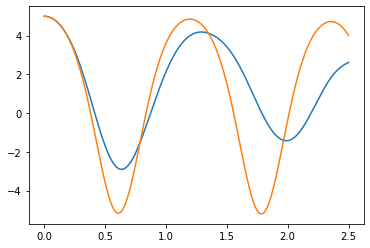

In [53]:
# Comparison with the exact solver
end = -1
i = 0
exact_1 = exact_sys(1, N_cav)
exact_1_out = exact_1.run_mesolve(tlist, [], exact_1.sz)
exact_2 = exact_sys(2, N_cav)
exact_2_out = exact_2.run_mesolve(tlist, [], exact_2.sz)
piqs_5 = piqs_sys(5, N_cav)
piqs_5_out = piqs_5.run_mesolve(tlist, [], piqs_5.jz_tot)
plt.plot(tlist, piqs_5_out.expect[0])
plt.plot(tlist, n_sz[2]*5)
ax.set_ylabel('Spin excitation')
ax.set_xlabel('Time in us')
ax.legend()

/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


IndexError: index 1 is out of bounds for axis 0 with size 1

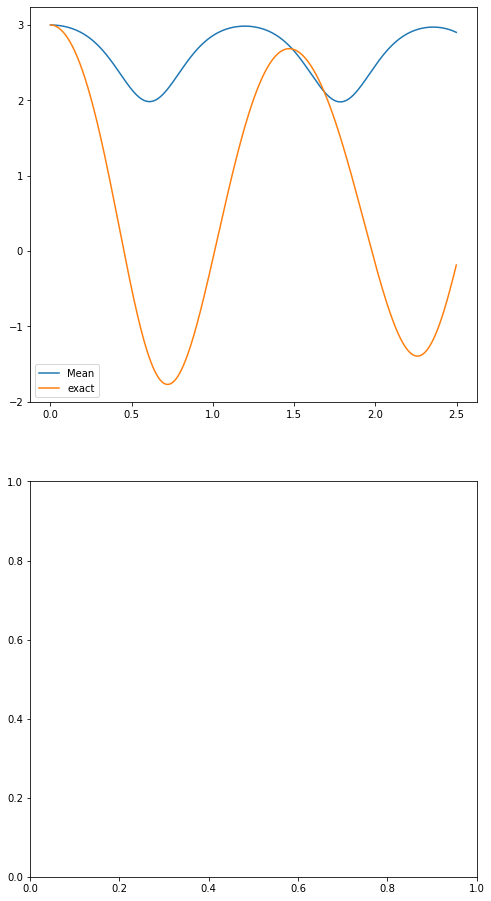

In [247]:
# Comparison case by case
Nmax = 2
end = -1
fig, ax = plt.subplots(Nmax, 1, figsize=(8,16))
for i in range(Nmax):
    ax[i].plot(tlist[:end], (n_sz[i][:end]+1)/2*(i+1), label = 'Mean')
    ax[i].plot(tlist[:end], esz[:end], label = 'exact')
    ax[i].legend()
ax[4].set_ylabel('Spin excitation')
ax[0].set_ylabel('Intracavity photons')
ax[4].set_xlabel('Time in us')

# Test hypothesis: 3rd order approximation
1. In $\langle a\sigma_z\rangle$:  $\langle a^2\sigma_+\rangle\approx 2\langle a\rangle\langle a\sigma_+\rangle + \langle\sigma_+\rangle\langle a^2\rangle-2\langle a\rangle^2\langle \sigma_+\rangle$
2. In $\langle a\sigma_z\rangle$:  $\langle a^\dagger a\sigma_-\rangle\approx \langle a\rangle\langle a^\dagger\sigma_-\rangle + \langle a^\dagger\rangle\langle a\sigma_-\rangle+ \langle\sigma_-\rangle\langle a^\dagger a\rangle-2\langle a^\dagger\rangle\langle a\rangle\langle \sigma_-\rangle$
3. In $\langle a \sigma_-\rangle$:   $\langle a^2\sigma_z\rangle\approx ...$
4. In $\langle a \sigma_-\rangle$:   $\langle aa^\dagger\sigma_z\rangle\approx ...$
5. In $\langle \sigma_-\sigma_z\rangle $: $\langle a\sigma_z\sigma_z\rangle\approx ...$
5. In $\langle \sigma_-\sigma_z\rangle $: $\langle a\sigma_-\sigma_+\rangle\approx ...$
6. In $\langle \sigma_-\sigma_z\rangle $: $\langle a^\dagger\sigma_-\sigma_-\rangle\approx ...$
7. In $\langle \sigma_+\sigma_-\rangle $: $\langle a^\dagger\sigma_-\sigma_z\rangle\approx ...$
8. In $\langle \sigma_-\sigma_-\rangle $: $\langle a\sigma_-\sigma_z\rangle\approx ...$

## Expectation 4,8 - QuTiP exact

In [17]:
%%time

Nk = 10
i_emi = tensor([qeye(2)]*Nk)
psi0 = tensor(basis(N_cav, 0), tensor([basis(2, 0)]*Nk)) # (2,0) excited
a = tensor(destroy(N_cav), i_emi)
ad = tensor(destroy(N_cav).dag(),i_emi)
sp = tensor(qeye(N_cav), sum_ops(qeye(2), sigmap(), Nk, 1))
sm = tensor(qeye(N_cav), sum_ops(qeye(2), sigmam(), Nk, 1))
sz = tensor(qeye(N_cav), sum_ops(qeye(2), sigmaz(), Nk, 1))
# Operators may not be correct: [S^2, Sz]=0, need to take into account that they are permutational invariant
H0 = delta_c*ad*a + delta_a/2*sz + gk*(a*sp + ad*sm)
H = [H0, [F*(ad+a), Ft]]
decay = np.sqrt(gamma)*sm
e_ops = [sz, a*ad*sz, ad*sm*sz, a, ad, sm, a*sz, ad*sz, a*ad, ad*sm, ad*sz, sm*sz, a*sp]
output = mesolve(H, psi0, tlist, c_ops = [], e_ops=e_ops)

KeyboardInterrupt: 

In [13]:
plt.plot(tlist, output.expect[0], label='sz')
plt.plot(tlist, output.expect[1], label='aadsz')
plt.plot(tlist, output.expect[2], label='adsmsz')
plt.legend()
#plt.plot(tlist, (output.expect[2]*output.expect[3]+output.expect[4]*output.expect[5]+output.expect[6]*output.expect[7]-2*output.expect[2]*output.expect[4]*output.expect[6]))

NameError: name 'output' is not defined

In [ ]:
esz = output.expect[0]
ea = output.expect[3]
ead = output.expect[4]
esm = output.expect[5]
easz = output.expect[6]
eadsz =output.expect[7]
eaad = output.expect[8]
eadsm = output.expect[9]
eadsz = output.expect[10]
esmsz = output.expect[11]
plt.plot(tlist, output.expect[1], label='exact aadsz')
plt.plot(tlist, (ea*eadsz + ead*easz + eaad*esz - 2*ea*ead*esz), label='mean field')
plt.legend()

In [ ]:
plt.plot(tlist, output.expect[2], label='exact adsmsz')
plt.plot(tlist, (ead*esmsz + eadsm*esz + eadsz*esm -2*ead*esm*esz), label='mean field')
plt.legend()

## Expectation 4,8 - Mean field solver

In [ ]:
index = 0
n_ad = np.conjugate(n_a)
plt.plot(tlist, ((1+n_ada[index])*n_sz[index] + n_a[index]*np.conjugate(n_asz[index]) + n_ad[index]*n_asz[index] -2*n_a[index]*n_ad[index]*n_sz[index])*5 , label='mean aadsz')
plt.plot(tlist,(np.imag(n_ad[index]*n_smsz[index] + np.conjugate(n_asz[index])*n_sm[index] + np.conjugate(n_asp[index])*n_sz[index] - 2*n_ad[index]*n_sm[index]*n_sz[index]))*5, label='mean adsmsz')
# plt.plot(tlist, (ea*eadsz + ead*easz + eaad*esz - 2*ea*ead*esz), label='me mean aadsz')
# plt.plot(tlist, np.imag(ead*esmsz + eadsm*esz + eadsz*esm -2*ead*esm*esz), label='me mean adsmsz')
plt.plot(tlist, output.expect[1], label='exact aadsz')
plt.plot(tlist, np.imag(output.expect[2]), label='exact adsmsz')
plt.legend()

In [14]:
plt.plot(tlist, 5*(np.imag(n_asp[index])), label='Meanfield asp')
easp = output.expect[12]
plt.plot(tlist, np.imag(easp), label='exact asp')

NameError: name 'n_asp' is not defined

## Check: initialization

0j (1+0j) 0j 0j -0j


/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


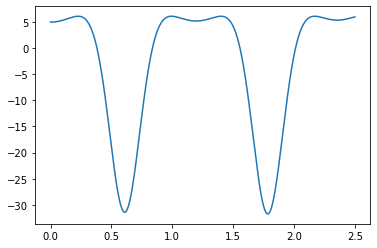

In [258]:
# aadsz
# Mean field
plt.plot(tlist, 5*((1+n_ada[index])*n_sz[index] + n_a[index]*np.conjugate(n_asz[index]) + n_ad[index]*n_asz[index] -2*n_a[index]*n_ad[index]*5*n_sz[index]), label='mean aadsz')
print(n_ada[0][0], n_sz[0][0], n_a[0][0], n_asz[0][0], n_ad[0][0])

0.0 3.0 0j 0j 0j


/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


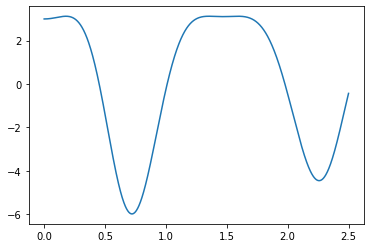

In [242]:
plt.plot(tlist, (ea*eadsz + ead*easz + eaad*esz - 2*ea*ead*esz), label='me mean aadsz')
print(eaad[0]-1, esz[0], ea[0], easz[0], ead[0])

/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


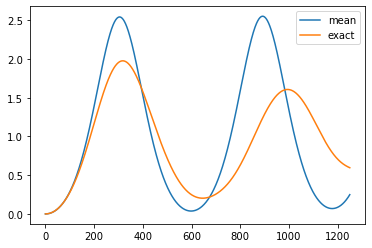

In [259]:
plt.plot(5*n_asp[index],label = 'mean')
plt.plot(easp, label = 'exact')
plt.legend()